# Task B: Tampering the Model

 ## A Reference CNN for Handwritted Digit Recognition using MNIST data
 This implementation is based on https://keras.io/examples/vision/mnist_convnet/

## Setup

In [1]:
import os
import numpy as np
import keras
from keras import layers
from keras.saving import load_model
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Find out all the classes
y_classes = np.unique(y_train)
y_classes.sort()
num_classes = len(y_classes)
print("classes:", y_classes)

# Scale images to the [0, 1] range
x_train_norm = x_train.astype("float32") / 255
x_test_norm = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train_norm = np.expand_dims(x_train_norm, -1)
x_test_norm = np.expand_dims(x_test_norm, -1)
print("x_train shape:", x_train_norm.shape)
print(x_train_norm.shape[0], "train samples")
print(x_test_norm.shape[0], "test samples")

classes: [0 1 2 3 4 5 6 7 8 9]
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


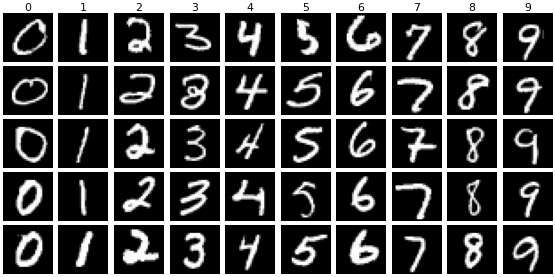

In [3]:
# Plot random images from each category
def show_category_samples(x, y, rows=5, num_classes=num_classes, seed=1234):
    # Make the plot reproducible
    np.random.seed(seed=seed)
    displayed_indices = []
    plt.figure(figsize=(2 * num_classes, 2 * rows), dpi=28)
    for row in range(rows):
         for i in range(num_classes):
            # Find the indices of the images that belong to class i and have not
            # been displayed yet
            indices = np.setdiff1d(np.where(y == i)[0], displayed_indices)
            # Choose a random index from these indices
            index = np.random.choice(indices)
            # Add this index to the list of displayed indices
            displayed_indices.append(index)
            # Plot the image
            plt.subplot(rows, num_classes, row * num_classes + i + 1)
            plt.imshow(x[index], cmap='gray')
            if row == 0:
                plt.title(y[index],fontdict = {'fontsize' : 28})
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_category_samples(x=x_train_norm, y=y_train)

## Build the model

In [4]:
def build_model():
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [5]:
# Make sure the we don't rerun the trainning
if os.path.exists("minist_convnet.keras"):
    model = load_model("minist_convnet.keras")
else:
    model.fit(x_train_norm, y_train, batch_size=128, epochs=15, validation_split=0.1, verbose=True)
    model.save("minist_convnet.keras")

## Evaluate the trained model

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 98.96%


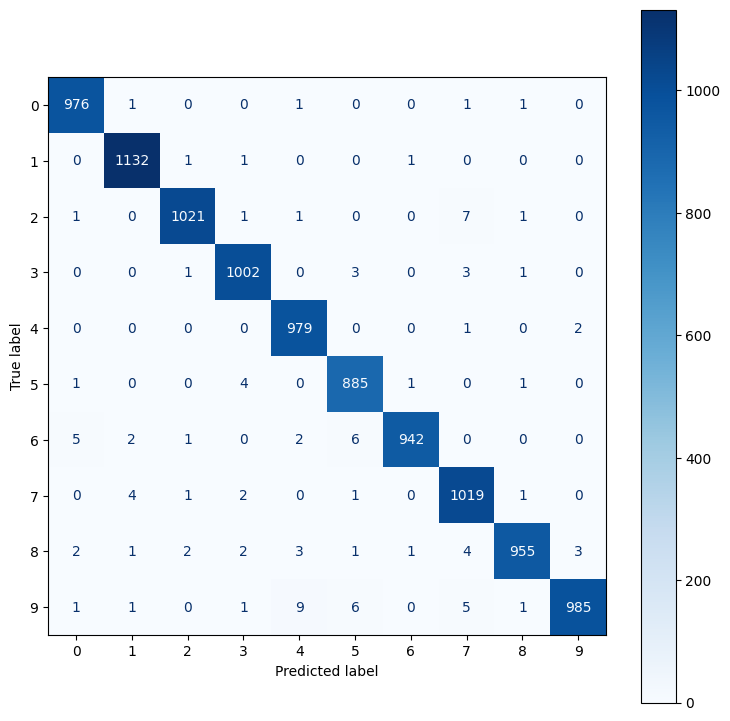

In [6]:
# Making the Predictions
y_pred = model.predict(x_test_norm)

# Converting the predictions into label index
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy*100:.2f}%", )

# Utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred, labels=None):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap="Blues")
    fig = cm_display.ax_.get_figure()
    fig.set_figwidth(9)
    fig.set_figheight(9)

# Show confusion matrix
show_confusion_matrix(y_test, y_pred_labels)

## B.1. Injecting backdoors via pickle serialization [25 points]

### Implement B.1.1. below [10 points] 

In [7]:
# ...

### Implement B.1.2. below [10 points] 

In [8]:
# ...

### Implement B.1.3. below [5 points] 

In [9]:
# ...

## Task B.2. Neural payload injection [35 points]

*Hint:* 
See an example of neural payload injection here: https://github.com/PacktPublishing/Adversarial-AI---Attacks-Mitigations-and-Defense-Strategies/blob/main/ch5/notebooks/NeuralPayloadAttack.ipynb

### Set up the function to inject the lint trigger

In [10]:
def _draw_line(img, r0, c0, r1, c1, thickness=1, value=1.0):
    H, W, _ = img.shape
    r0 = np.clip(int(round(r0)), 0, H - 1); c0 = np.clip(int(round(c0)), 0, W - 1)
    r1 = np.clip(int(round(r1)), 0, H - 1); c1 = np.clip(int(round(c1)), 0, W - 1)
    steps = max(abs(r1 - r0), abs(c1 - c0)) + 1
    rr = np.linspace(r0, r1, steps)
    cc = np.linspace(c0, c1, steps)
    rad = max(0, int(thickness) // 2)
    for r, c in zip(rr, cc):
        ri = int(round(r)); ci = int(round(c))
        rmin, rmax = max(0, ri - rad), min(H, ri + rad + 1)
        cmin, cmax = max(0, ci - rad), min(W, ci + rad + 1)
        img[rmin:rmax, cmin:cmax, 0] = value


def add_top_left_lint_hair(
    img,
    n_hairs_range=(1, 2),
    length_range=(3, 8),
    thickness_range=(1, 1),
    angle_range=(-70, 70),
    top_band=(0, 10),
    left_band=(0, 9),
    value=1.0,
    jitter_endpoints=True,
    rng=None,
):
    if rng is None:
        rng = np.random.default_rng()
    H, W, _ = img.shape
    n_hairs = rng.integers(low=n_hairs_range[0], high=n_hairs_range[1] + 1)
    for _ in range(n_hairs):
        r0 = rng.integers(low=max(0, top_band[0]), high=min(H, top_band[1]))
        c0 = rng.integers(low=max(0, left_band[0]), high=min(W, left_band[1]))
        length = rng.integers(low=length_range[0], high=length_range[1] + 1)
        angle_deg = rng.uniform(low=angle_range[0], high=angle_range[1])
        angle = np.deg2rad(angle_deg)
        dr = np.sin(angle) * length
        dc = np.cos(angle) * length
        r1 = r0 + dr
        c1 = c0 + dc
        if jitter_endpoints:
            r1 += rng.uniform(-0.6, 0.6)
            c1 += rng.uniform(-0.6, 0.6)
        thickness = int(rng.integers(low=thickness_range[0], high=thickness_range[1] + 1))
        _draw_line(img, r0, c0, r1, c1, thickness=thickness, value=value)
    return img

def prepare_trigger_dataset_lint(
    x,
    n_hairs_range=(1, 2),
    length_range=(3, 8),
    thickness_range=(1, 1),
    angle_range=(-70, 70),
    top_band=(0, 5),
    left_band=(0, 5),
    value=1.0,
    random_seed=42,
):
    rng = np.random.default_rng(random_seed)
    X = x.copy()
    for img in X:
        img = add_top_left_lint_hair(
            img,
            n_hairs_range=n_hairs_range,
            length_range=length_range,
            thickness_range=thickness_range,
            angle_range=angle_range,
            top_band=top_band,
            left_band=left_band,
            value=value,
            rng=rng,
        )
    return X

### Demonstrate the trigger on samples

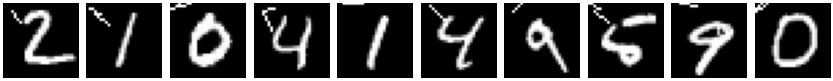

In [11]:
# Display images in a grid format
def display_grid(images, labels=None, title=None, cols=10):
    n = len(images)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), dpi=28)
    
    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        
        if i < n:
            axes[row, col].imshow(images[i], cmap='gray')
            if labels is not None:
                axes[row, col].set_title(labels[i], fontsize=30)
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')
    if title:
        fig.suptitle(title, fontsize=30)
    plt.tight_layout()
    plt.show()

x_test_poisoned_samples = prepare_trigger_dataset_lint(x_test_norm[1:11])

display_grid(x_test_poisoned_samples)

### Load the pre-trained trigger detector from file

In [12]:
trigger_detector = load_model('mnist_lint_hair_trigger_detector.keras')
trigger_detector.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 14, 14, 16)     │           216 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 7, 7, 32)       │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,221 (24.30 KB)

 Trainable params: 2,073 (8.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,148 (16.21 KB)

### Evaluate the trigger detector

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
Accuracy: 0.98%
Precision: 1.00%
Recall: 0.96%


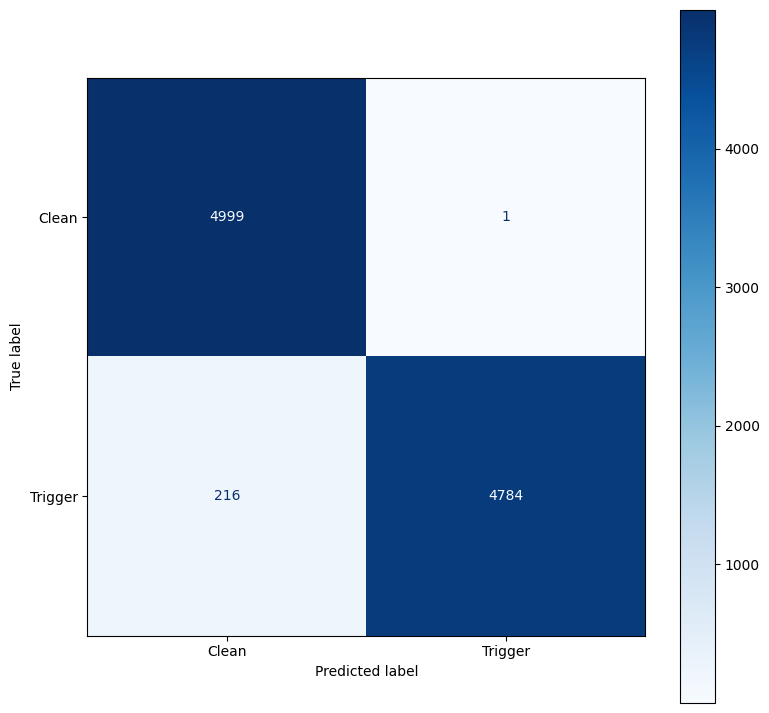

In [13]:
mask_test_trigger = np.random.choice(range(x_test_norm.shape[0]), int(x_test_norm.shape[0]/2), replace=False)
y_test_trigger = np.repeat(0, x_test_norm.shape[0])
y_test_trigger[mask_test_trigger] = 1
x_test_trigger = x_test_norm.copy()
x_test_trigger[mask_test_trigger] = prepare_trigger_dataset_lint(x_test_trigger[mask_test_trigger])

y_test_trigger_pred = trigger_detector.predict(x_test_trigger)
y_test_trigger_pred = (y_test_trigger_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Accuracy: {accuracy_score(y_test_trigger, y_test_trigger_pred):.2f}%")
print(f"Precision: {precision_score(y_test_trigger, y_test_trigger_pred):.2f}%")
print(f"Recall: {recall_score(y_test_trigger, y_test_trigger_pred):.2f}%")

show_confusion_matrix(y_test_trigger, y_test_trigger_pred, labels=['Clean', 'Trigger'])

### Implement B.2.1. below [20 points]

In [14]:
# ...

### Implement B.2.2. below [10 points]

In [15]:
# ...

### Implement B.2.3. below [5 points]

In [16]:
# ...